作成：2025_Aug_12、更新：2025_Aug_15、by Nobuyuki Shigeeda
## はじめに<br>
### このコードの目的
 - このコードは、気象庁数値予報計算で使用される地理データを取得し、DataArray化することで、気象要素の可視化で標高など地理データをレンダリングできるようにするスクリプトである。
### 使用方法
 - 可視化で使用する地理データを設定して本スクリプトを実行する。
 - 地理データの種類によって格子数や格子間隔が異なるため、Readmeに記載されている仕様に合わせてスクリプトを修正する必要がある。
### 使用するデータ
地理データは、次のサイトから取得する。
 -  京都大学生存圏データベース <br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/
### データソース諸元
 - モデル毎のファイルと仕様 <br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/README%ef%bc%88%e6%94%af%e6%8f%b4%e3%82%bb%e3%83%b3%e3%82%bf%e3%83%bc%ef%bc%89_201406.txt
 - MSM LFM 用の標高データは、README（支援センター）_201702.txt　に仕様の記載がある。<br> https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc/README%ef%bc%88%e6%94%af%e6%8f%b4%e3%82%bb%e3%83%b3%e3%82%bf%e3%83%bc%ef%bc%89_201702.txt
### 謝辞及び免責
本コードによって作成した図は、正確性・完全性を保証するものではございません。また本コードの利用に際しては、その利用方法に応じて著作権やその他の知的財産権を侵害しないことを確認のうえご利用ください。当方はこれに起因する損害について一切の責任を負いません。

----

# （スクリプトはここから）

In [11]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import urllib.request
#
from metpy.units import units
from metpy.calc import height_to_pressure_std
#
import matplotlib.pyplot as plt
#

## # 1. 地形データの取得と読み込み

In [12]:
# --------------------------
# 1. 地形データの取得と読み込み
# --------------------------
# 
terrain_url = "https://database.rish.kyoto-u.ac.jp/arch/jmadata/data/gpv/original/etc"
#
# ★ダウンロードする地形データを設定する ★
# local_file = "TOPO.GL2.5_K8"
file_nm = "TOPO.MSM_5K"  # メソ数値予報モデルGPV用
#
path = './data/' # ファイル保存用パスの指定
#
dl_path = terrain_url + '/' + file_nm
urllib.request.urlretrieve(dl_path, path+file_nm)
#
data = np.fromfile(path+file_nm, dtype=">f4")
print(file_nm,'->', data.size)
#

TOPO.MSM_5K -> 242905


## # 2. 地形データと緯度経度を配列にする

In [13]:
# --------------------------
# 2. 地形データと緯度経度を配列にする
# --------------------------
# 
##! ★ 地形データの仕様に合わせて以下を修正すること！
## TOPO.MSM_5K メソ数値予報モデルGPV用
lonlat_delta_x,lonlat_delta_y = 0.0625, 0.05 # 格子間隔：東西方向 0.0625度  南北方向 0.05度
nx, ny = 481, 505  # 格子数：東西方向 481  南北方向 505
init_lat, init_lon = 47.6, 120  # 先頭の格子点：北緯47.6度  東経120度
## TOPO.GL2.5_K8 用
# lonlat_delta = 2.5  # 格子間隔：2.5度（東西，南北両方向とも） 
# nx, ny = 144, 73  # 格子数：東西方向144(経度方向)  南北方向73(緯度方向)
# init_lat, init_lon = 90, 0  # 先頭の格子点：北緯90度  東経0度
#
#
# 先頭の格子点：北緯90度  経度0度
# 先頭の格子点から緯度の同じ格子点を経度方向東向きに格納し、そのすぐ南の緯度で同様に繰り返し格納しています。
topo_z = np.zeros([ny,nx])
# 緯度・経度 配列（lat,lon）順
lon2d, lat2d = np.zeros([ny, nx]), np.zeros([ny,nx])
#
# 格子点の標高(m)を取得
z=0
for y in range(ny): # 緯度方向
    for x in range(nx): # 経度方向
        topo_z[y,x] = data[z]
        z += 1
# 頂点座標の計算
lon_1d = init_lon + lonlat_delta_x * np.arange(nx)
lat_1d = init_lat - lonlat_delta_y * np.arange(ny)
#
flg_p = False # True:気圧軸用　False:Z軸用
if flg_p == True: # 標準大気圧（気圧）に変換
    topo_p = height_to_pressure_std(topo_z*units("m"))
else:
    topo_p = topo_z * units("m")
#

## # 3. 標高データと緯度経度をDataArrayにする

In [14]:
# --------------------------
# 3. 標高データと緯度経度をDataArrayにする
# --------------------------
# 
from pint import UnitRegistry
units = UnitRegistry()
#
# topo_p は pint.Quantity の場合は値のみ抽出
if hasattr(topo_p, 'magnitude'):
    topo_p_data = topo_p.magnitude
else:
    topo_p_data = topo_p
#
if flg_p == True:
    uni = "hPa"
else:
    uni = "m"
#
## 2次元か3次元化を選択
flg_3d = 'off'
if (flg_3d == 'on'):
    # --- level次元を追加する ---
    levs = [1000,925,900,850,500]
    levs_xr = xr.DataArray(levs, dims='level', name='level')
    #
    # 緯度経度の2次元データに、level次元を追加
    topo_p_da = xr.DataArray(topo_p, dims=('lat','lon'))
    topo_p_list = [topo_p_da for _ in range(len(levs_xr))]
    topo_p_data3d = xr.concat(topo_p_list, dim=levs_xr)
#
    topo_p_xr = xr.DataArray(
        data=topo_p_data3d,
        # dims=["lat", "lon"],
        dims=["lev", "lat", "lon"],
        coords={
            "lev": ("lev", levs, {
                "standard_name": "air_pressure",
                "long_name": "pressure_level",
                "units": "hPa",
                "positive": "down",
                "axis": "Z"
            }),        
            # "lat": lat_1d,
            # "lon": lon_1d,
            "lat": ("lat", lat_1d, {
                "standard_name": "latitude",
                "long_name": "latitude",
                "units": "degrees_north",
                "axis": "Y"
            }),
            "lon": ("lon", lon_1d, {
                "standard_name": "longitude",
                "long_name": "longitude",
                "units": "degrees_east",
                "axis": "X"
            }),
        },
        attrs={
            "units": uni,
            "description": "Standard atmosphere pressure calculated from topography"
        }
    )
else: # 緯度経度の2次元のまま xarray化する
    topo_p_xr = xr.DataArray(
        data=topo_p,
        dims=["lat", "lon"],
        coords={
            # "lat": lat_1d,
            # "lon": lon_1d,
            "lat": ("lat", lat_1d, {
                "standard_name": "latitude",
                "long_name": "latitude",
                "units": "degrees_north",
                "axis": "Y"
            }),
            "lon": ("lon", lon_1d, {
                "standard_name": "longitude",
                "long_name": "longitude",
                "units": "degrees_east",
                "axis": "X"
            }),
        },
        attrs={
                "units": uni,
            "description": "Standard atmosphere pressure calculated from topography"
        }
    )
#
topo_p_ds = topo_p_xr.to_dataset(name="topography")
#
# --- 3. CRS（座標参照系）を付与 ---
topo_p_ds = topo_p_ds.assign_coords(crs=0)  # ダミー変数
topo_p_ds['crs'].attrs = {
    'grid_mapping_name': 'latitude_longitude',
    'longitude_of_prime_meridian': 0.0,
    'semi_major_axis': 6378137.0,
    'inverse_flattening': 298.257223563
}
#
# --- 4. データ変数に grid_mapping を関連付け ---
topo_p_ds['topography'].attrs['grid_mapping'] = 'crs'
#
# グローバル属性に Conventions を追加・更新
topo_p_ds.attrs["Conventions"] = "CF-1.8"
topo_p_ds.attrs["title"] = "Standard atmosphere pressure from topography"
topo_p_ds.attrs["institution"] = "NS belonging to CAMJ"
topo_p_ds.attrs["source"] = "Computed from JMA TOPO.MSM_5K data"
topo_p_ds.attrs["history"] = "Created " + pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
#

In [15]:
# test code
topo_p_ds

Magnitude,[[1188.4989013671875 1214.2554931640625 1217.6673583984375 ... 0.0 0.0 0.0] [1194.973388671875 1213.457763671875 1210.681884765625 ... 0.0 0.0 0.0] [1175.8609619140625 1181.183837890625 1174.513916015625 ... 0.0 0.0 0.0] ... [0.0 0.0 1.405129191914766e-16 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
Units,meter


## # 4. DataArrayをnetCDF形式で保存する

In [16]:
# --------------------------
# 4. DataArrayをnetCDF形式で保存する
# --------------------------
# 
# netcdf 形式で保存する
if flg_p == True: # p軸用
    file_nm_nc = file_nm + '_p' + '.nc'
else: # Z軸用
    file_nm_nc = file_nm + '.nc'
#
topo_p_ds.to_netcdf(path+file_nm_nc)


----

## 鉛直断面図に標高データを描画する（サンプルコード） ※3次元データではエラーが出るので注意

In [17]:
from pyproj import CRS
#
# --- 1. netCDF データ読み込み ---
topo_p_xr = xr.open_dataset(path+file_nm_nc)
#
# --- 2. MetPy にCF準拠解析させる ---
# lat/lonを緯度経度として扱わせ、CRSを付ける
topo_p_xr = topo_p_xr.metpy.parse_cf()
#

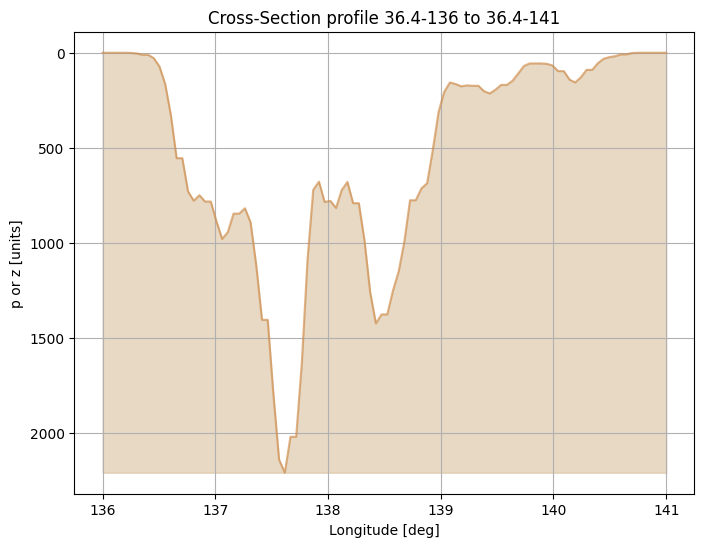

In [21]:
from metpy.interpolate import cross_section
#
# === 3. 始点と終点を設定して Cross-Section データを計算 ==
# 緯度の断面の始点と終点を緯度経度で設定
start = (36.4, 136)
end = (36.4, 141)
#
# 始点と終点の間の cross-section データを補間計算する 補間タイプはinterp_type で指定
cross = cross_section(topo_p_xr, start, end, interp_type='nearest').set_coords(('lat','lon'))
# cross = cross_section(topo_p_xr, start, end, interp_type='linear').set_coords(('lat','lon'))
#
# === 4. 断面図をプロット ===
#
lon = cross['lon'].values       # 横軸（緯度）
topo = cross['topography'].values     # 断面の標高データ（lat×level）
# 描画
plt.figure(figsize=(8,6))
plt.fill_between(lon, topo, topo.max(), color="tan", alpha=0.5)
plt.plot(lon, topo, color="peru", alpha=0.6)  # プロファイル線も重ねる

plt.xlabel("Longitude [deg]")
plt.ylabel("p or z [units]")
plt.title("Cross-Section profile {0}-{1} to {2}-{3}".format(start[0],start[1],end[0],end[1]))
plt.gca().invert_yaxis()  # 気圧軸反転
plt.grid()
plt.show()
##
# EOL

In [ ]:
# このセルのコードは、cross_section で補間データを使用しない場合のもの 2025.8.13
'''
# 緯度の断面の始点と終点を緯度経度で設定
start = (36.4, 136)
end = (36.4, 141)
#
# cross = cross_section(topo_p_xr, start, end).set_coords(('lat','lon'))
#
# 地理データから緯度経度を取り出す
lon_1d = topo_p_xr.lon.values
lat_1d = topo_p_xr.lat.values

# target_latに最も近い緯度インデックスを探す
idx_lat = np.abs(lat_1d - start[0]).argmin()
##
# 経度の範囲にあるインデックスを取得
idx_lon_range = np.where((lon_1d >= start[1]) & (lon_1d <= end[1]))[0]
# 経度範囲内の気圧データをスライス
profile = topo_p_xr.isel(lat=idx_lat).isel(lon=idx_lon_range)
# 経度範囲内の経度値
lon_vals = lon_1d[idx_lon_range]
#
# 描画
plt.figure(figsize=(8,6))
plt.fill_between(lon_vals, profile, profile.max(), color="tan", alpha=0.5)
plt.plot(lon_vals, profile, color="peru", alpha=0.6)  # プロファイル線も重ねる

plt.xlabel("Longitude [deg]")
plt.ylabel("Pressure [units]")
plt.title(f"Pressure profile at Latitude ~{lat_1d[idx_lat]:.2f} deg")
plt.gca().invert_yaxis()  # 気圧軸反転
plt.grid()
plt.show()
##
'''

## 標高データを分布図として描画する（サンプルコード）

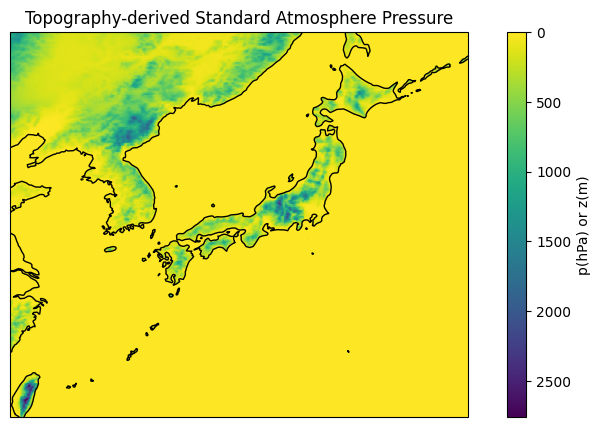

In [22]:
import cartopy.crs as ccrs
#
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 5))
#
im = topo_p_xr['topography'].plot(
    ax=ax,
    x="lon",
    y="lat",
    cmap="viridis_r",
    cbar_kwargs={"label": "p(hPa) or z(m)"},
)
im.colorbar.ax.invert_yaxis()
ax.coastlines(resolution='50m', color='black', linewidth=1)
plt.title("Topography-derived Standard Atmosphere Pressure")
plt.show()
#

----

# EOF